In [139]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import pandas as pd
from scipy import stats

In [147]:
def get_exps_data(base_path):
    exp_dirs = os.listdir(base_path)
    exp_data = {
        'Title': [],
        'Margin S': [],
        'Margin D': [],
        'Losses': [],
        'Mean Losses': [],
        'Hedged Scores': [],
        'True Scores': []
    }
    for exp_dir in sorted(exp_dirs):
        exp_dir_path = os.path.join(base_path, exp_dir)
        if os.path.isdir(exp_dir_path):
            params_path = os.path.join(exp_dir_path, 'hyperparameters.json')
            assert os.path.exists(params_path)
            with open(params_path, 'r') as f:
                params = json.loads(f.read())
            exp_data['Title']\
                .append(f"margin_s: {params['margin_s']:<04},"
                        f"margin_d: {params['margin_d']:<04},")
            exp_data['Margin S'].append(params['margin_s'])
            exp_data['Margin D'].append(params['margin_d'])
            losses_path = os.path.join(exp_dir_path,
                                       'undistorted',
                                       f"{exp_dir}_raw_losses.npy")
            assert os.path.exists(losses_path)
            losses = np.load(losses_path)
            exp_data['Losses'].append(losses)
            exp_data['Mean Losses'].append(np.mean(losses, axis=0))
            hedged_scores_path = os.path.join(exp_dir_path,
                                              'undistorted',
                                              f"{exp_dir}"
                                              "_all_eval_hedged_scores.csv")
            assert os.path.exists(hedged_scores_path)
            hedged_scores = pd.read_csv(hedged_scores_path,
                                        index_col=None)
            hedged_overall = hedged_scores['overall'].iloc[-1]
            hedged_sub_overall = hedged_scores['sub_overall'].iloc[-1]
            exp_data['Hedged Scores'].append((hedged_overall,
                                              hedged_sub_overall))

            true_scores_path = os.path.join(exp_dir_path,
                                            'undistorted',
                                            f"{exp_dir}"
                                            "_all_eval_true_scores.csv")
            assert os.path.exists(true_scores_path)
            true_scores = pd.read_csv(true_scores_path,
                                      index_col=None)
            true_overall = true_scores['overall'].iloc[-1]
            true_sub_overall = true_scores['overall'].iloc[-1]
            exp_data['True Scores'].append((true_overall,
                                            true_sub_overall))
    return exp_data

In [ ]:
def plot_fit_line(q, batch_numbers, mean_losses, color):
    split_point = len(batch_numbers) // 4 * q
    x = batch_numbers[split_point:]
    y = mean_losses[split_point:]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.log(y))

    x_fit = np.linspace(split_point, max(batch_numbers), 100)
    y_fit = np.exp(slope * x_fit + intercept)
    if q == 0:
        label_prefix = "Full run"
    elif q == 3:
        label_prefix = "Final quarter"
    else:
        label_prefix = f"Final {4-q} quarters"
    plt.plot(x_fit, y_fit, '--', color=color, label=f'{label_prefix} Trend (slope={slope:.2e})')

    # Print statistics
    print(f"Slope: {slope:.2e}")
    print(f"R-squared: {r_value**2:.3f}")
    print(f"P-value: {p_value:.3e}")

In [148]:
base_path = "/Users/zacbolton/dev/BSc/FP/historical_av_with_SBERT/saved_experiments/grid_search_margin_s_margin_d"
exps_data = get_exps_data(base_path)

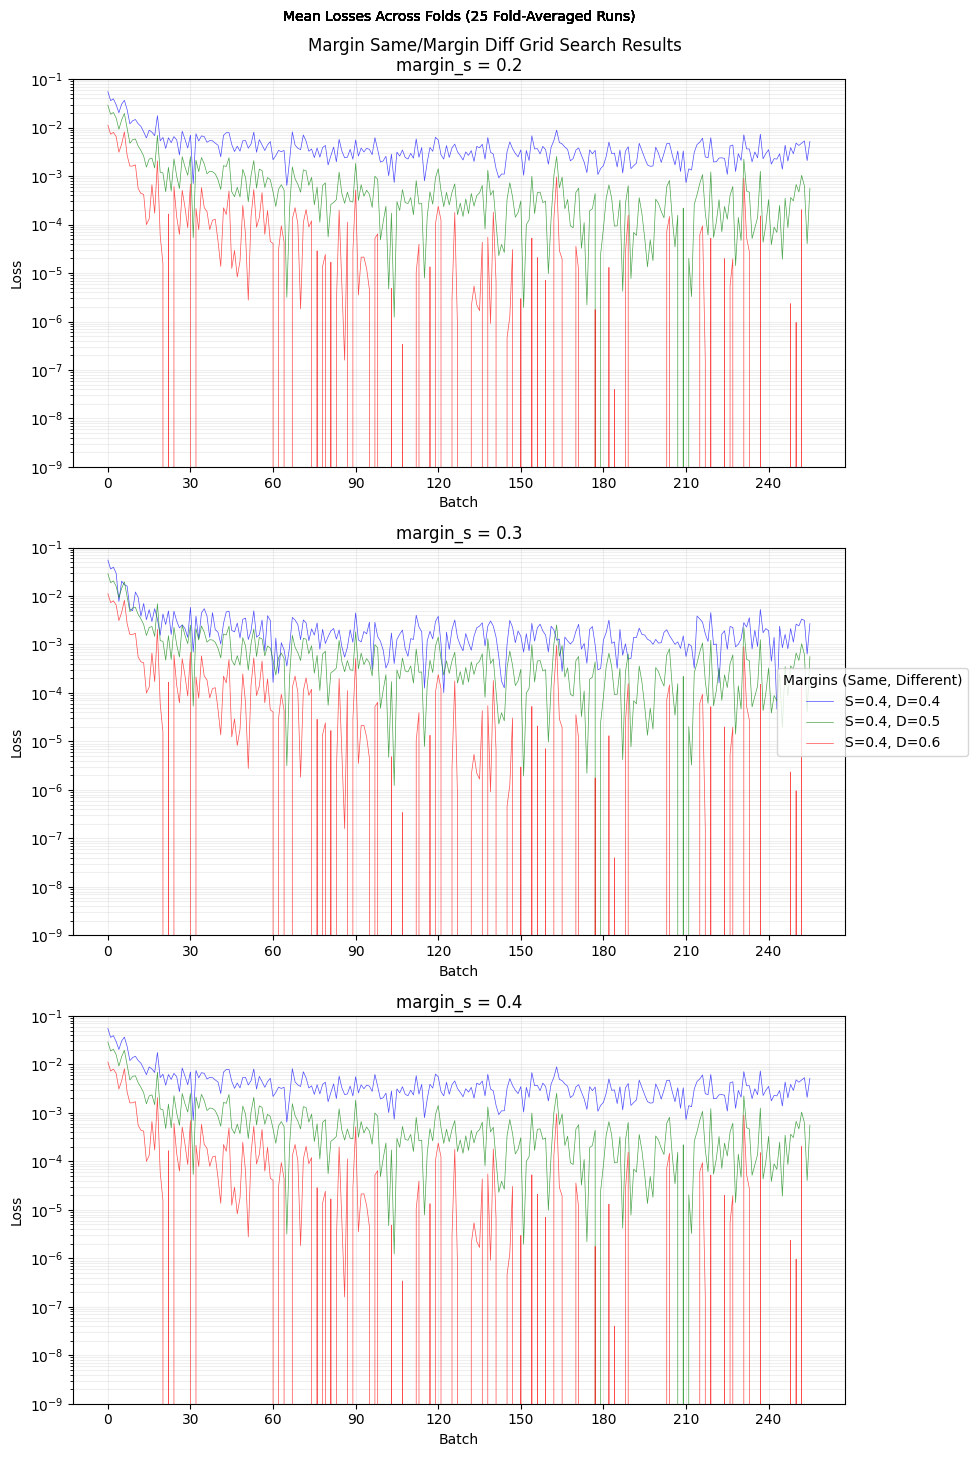

In [180]:
# fig, ax = plt.subplots(figsize=(10, 6))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
axes = {0.2: ax1, 0.3: ax2, 0.4: ax3}

num_epochs = exps_data['Losses'][-1].shape[0]
num_batches_per_epoch = exps_data['Losses'][-1].shape[1]

margin_d_colors = {
    0.4: 'b',
    0.5: 'g',
    0.6: 'r'
}
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.set_ylim(0.000000001, 0.1)
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for title, mean_losses, margin_s, margin_d in zip(
   exps_data['Title'],
   exps_data['Mean Losses'],
   exps_data['Margin S'],
   exps_data['Margin D']):
    if margin_s in [0.25, 0.35] or margin_d in [0.45, 0.55]:
        continue
    ax = axes[margin_s]
    color = margin_d_colors[margin_d]

    batch_numbers = np.arange(len(mean_losses))
    ax.plot(batch_numbers, mean_losses, color+'-', alpha=0.7,
            label=f'S={margin_s:.1f}, D={margin_d:.1f}', linewidth=0.5)
    ax.set_title(f'margin_s = {margin_s}')

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.grid(True)

    fig.suptitle("Margin Same/Margin Diff Grid Search Results", y=0.95)
    ax1.text(0.5, 1.15, "Mean Losses Across Folds (25 Fold-Averaged Runs)",
             horizontalalignment='center',
             transform=ax1.transAxes)

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels,
           title='Margins (Same, Different)',
           loc='center right',
           bbox_to_anchor=(0.98, 0.5))


In [181]:
score_data = {}
targ_cols = [
    'Title',
    'Margin S',
    'Margin D',
    'Hedged Scores',
    'True Scores'
]
val_data = {
    'Title': [],
    'Margin S': [],
    'Margin D': [],
    'Hedged Scores (overall)': [],
    'Hedged Scores (sub_overall)': [],
    'True Scores (overall)': [],
    'True Scores (sub_overall)': []
}
for k in exps_data:
    if k in targ_cols:
        if k.endswith(' Scores'):
            if k.startswith('Hedged '):
                val_data['Hedged Scores (overall)'] = [i for i, j in exps_data[k]]
                val_data['Hedged Scores (sub_overall)'] = [j for i, j in exps_data[k]]
            elif k.startswith('True '):
                val_data['True Scores (overall)'] = [i for i, j in exps_data[k]]
                val_data['True Scores (sub_overall)'] = [j for i, j in exps_data[k]]
        else:
            val_data[k] = exps_data[k]

df_exp_data = pd.DataFrame(val_data)

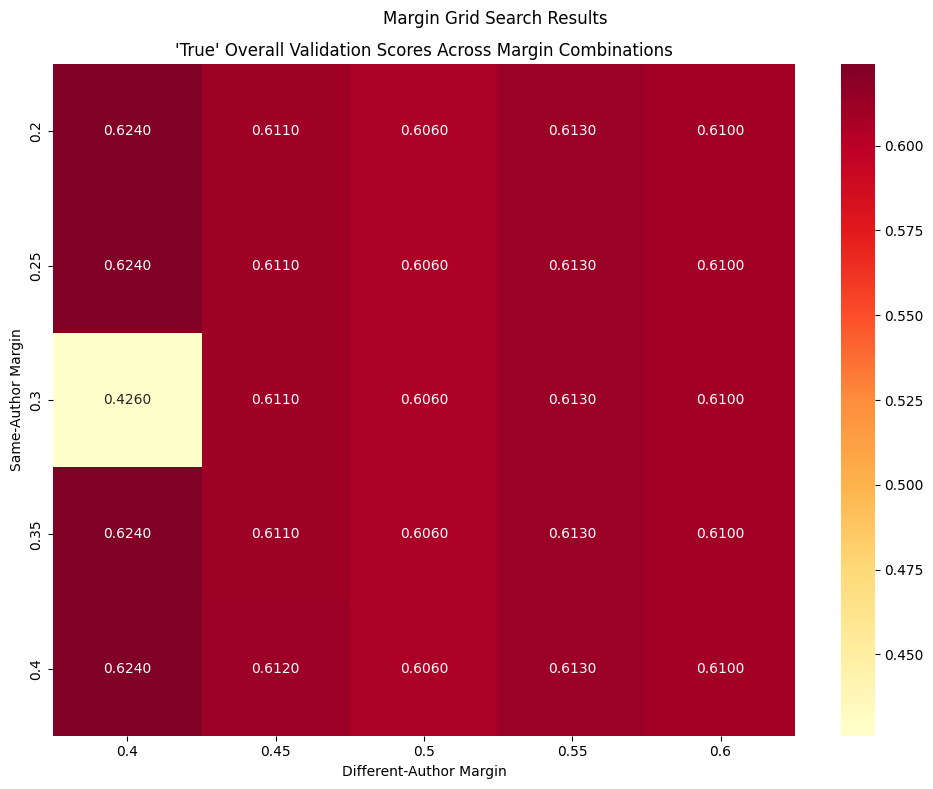


Pivot Table Structure:
Margin D   0.40   0.45   0.50   0.55  0.60
Margin S                                  
0.20      0.624  0.611  0.606  0.613  0.61
0.25      0.624  0.611  0.606  0.613  0.61
0.30      0.426  0.611  0.606  0.613  0.61
0.35      0.624  0.611  0.606  0.613  0.61
0.40      0.624  0.612  0.606  0.613  0.61


In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df_exp_data.pivot_table(
    values='True Scores (overall)',
    index='Margin S',
    columns='Margin D'
)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(pivot,
            annot=True,
            fmt='.4f',
            cmap='YlOrRd',
            ax=ax)

plt.xlabel('Different-Author Margin')
plt.ylabel('Same-Author Margin')

plt.suptitle("Margin Grid Search Results")
plt.title("'True' Overall Validation Scores Across Margin Combinations")

plt.tight_layout()
plt.show()

print("\nPivot Table Structure:")
print(pivot)